In [225]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

from timeit import default_timer as timer
import cv2
import os
from os import listdir
import matplotlib.pyplot as plt
import importlib
import scipy.misc
import numpy as np
from sklearn import svm

import sys
sys.path.insert(0, 'scripts/')
import helper
# from helper import *
import prepare_lib
# from prepare_lib import *
import classify_lib
# from classify_lib import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
### file:

# pn = 'images/train/10/20171118_133018.jpg' ### läuft gut mit gray/thres
# pn = 'images/test/10/DSC_0043.JPG'   ### läuft mit 8px,adap
# pn = 'images/train/10/DSC_0035.JPG'  # läuft NICHT ----> selective search wählt symbol nicht aus!
# pn = 'images/train/10/DSC_0071.JPG'  # läuft NICHT
# pn = 'images/train/10/20171118_130352.jpg'
pn = 'images/train/11/20171118_130234.jpg'

img = prepare_lib.prepareImage(pn)

## Pre-processing

In [3]:
start = timer()

gray_eq = img.equalize_gray_Hist()
gray_CLAHE = img.equalize_gray_Hist_CLAHE()

edges_eq = img.edgeDetector(gray_eq)
edges_CLAHE = img.edgeDetector(gray_CLAHE)
edges = edges_eq + edges_CLAHE
# print(edges_eq.shape)
# print(edges.shape)

# # Hough
HoughLines = img.hough_transformation_line(edges, 0.15)

# get mask
mask, hull = helper.extractMask(img.img.shape[0], img.img.shape[1], HoughLines)
# print(np.shape(mask))
# print(np.shape(img))

# perform GrabCut
imgGC = img.performGrabCut(mask, 6)

# cut image
imgCut = img.cutImage(hull)

duration = timer() - start
print(duration)

plt.imshow(img.adapThres, cmap='gray')

print(img.gray.shape)

1.1154440569330908
(433, 853)


## Selective Search

In [4]:
import selectivesearch
import matplotlib.patches as mpatches

In [6]:
start = timer()

# get window candidates
candidates = img.performSelectiveSearch(scale=50, minRectSize = 200, w2h=1.8, useCutImage=True, sig=0.8, minSize=50)
print('number of candidates: ', len(candidates))

duration = timer() - start
print(duration)

number of candidates:  146
3.632095895627936


In [7]:
# draw rectangles on the original image
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(6, 6))
ax.imshow(img.imgCut)
for x, y, w, h in candidates:
#     print(x, y, w, h)
    rect = mpatches.Rectangle((x, y), w, h, fill=False, edgecolor='red', linewidth=2)
    ax.add_patch(rect)

plt.show()

## Distinguish 'Good' - 'Bad' candidates with an OCC

In [9]:
# parameter:

ppc = (10,10)

In [239]:
importlib.reload(classify_lib)
# print(listdir('scripts'))

path = 'C:/Users/alici/Uni/Bayer_Praktikum/szenario_status/images/train_icons/o_u_symbol/'
occ_clf = classify_lib.trainOneClassSVM(TrainPath = path, OutputPath='', imgSize = (32,32), ppc = ppc, gamma = 'auto')
print(occ_clf)



# occ_clf = joblib.load('scripts/models/Classifier.pkl')
# print(occ_clf)

OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto', kernel='rbf',
      max_iter=-1, nu=0.5, random_state=None, shrinking=True, tol=0.001,
      verbose=False)


C:\Users\alici\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


## Classify

In [241]:
path = 'images/train_icons/o_u_symbol/'
X_o_u_heat = np.array(classify_lib.extractTrainFeaturesMultiClass(path=path))
# print(np.array(X_o_u_heat).shape)

path = 'images/train_icons/anti_train/'
X_anti = np.array(classify_lib.extractTrainFeaturesMultiClass(path=path))
path_extr = 'images/train_icons/anti_extracted'
X_anti_extr = np.array(classify_lib.extractTrainFeaturesMultiClass(path=path_extr))

In [242]:
# haar = classify_lib.getResizedHaarFeature(img.adapThres)
# print(haar)
p = 'C:\\Users\\alici\\Uni\\Bayer_Praktikum\\szenario_status\\images\\train_icons\\o_u_symbol\\f1.jpg'
test = prepare_lib.prepareImage(p)
Xtest = classify_lib.getResizedHaarFeature(test.adapThres)
print(Xtest)

[ 5100     0  5100   762   381   381  9946  4846  9946 12750 11988  6375
  5994  6375  5994]


In [249]:
# X = np.concatenate((np.array(X_o_u_heat), np.array(X_anti)))
# y = np.concatenate((np.zeros(len(X_o_u_heat)), np.ones(len(X_anti))))

X = np.concatenate((np.array(X_o_u_heat), np.array(X_anti_extr)))
y = np.concatenate((np.zeros(len(X_o_u_heat)), np.ones(len(X_anti_extr))))

# X = np.concatenate((np.array(X_o_u_heat), np.array(X_anti), np.array(X_anti_extr)))
# y = np.concatenate((np.zeros(len(X_o_u_heat)), np.ones(len(X_anti)), 2*np.ones(len(X_anti_extr))))

print(X.shape, y.shape)
# print(X)

# multi-classification
clf = svm.SVC(decision_function_shape='ovr', C=10000, tol = 0.001, gamma = 0.00000001)
clf.fit(X, y)

(129, 15) (129,)


SVC(C=10000, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=1e-08, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

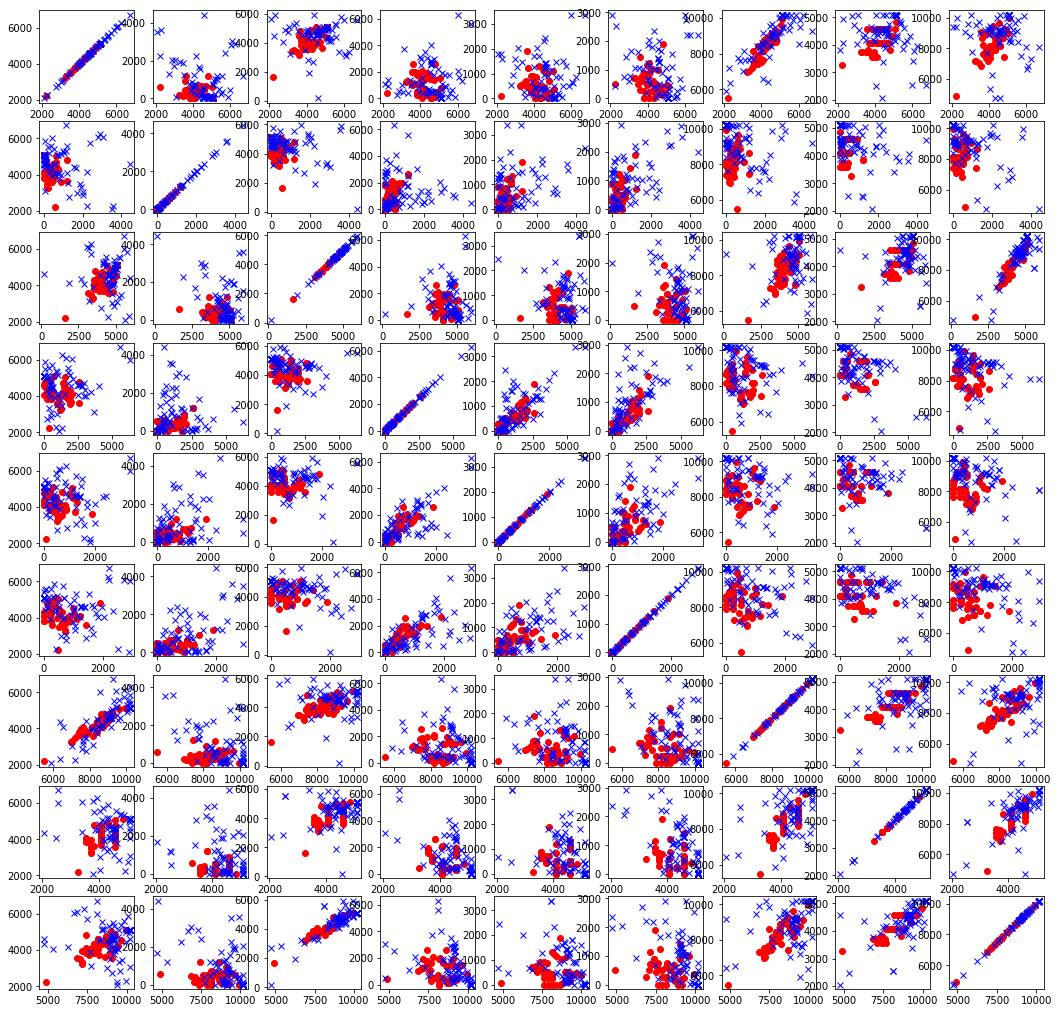

In [244]:
(q,n) = X.shape
k=1
plt.figure(figsize=(18,18))
for i in range(9):
    for j in range(9):
#         print(k)
        plt.subplot(9,9,k)
        plt.plot(X_o_u_heat[:,i], X_o_u_heat[:,j], 'ro')
#         plt.plot(X_anti[:,i], X_anti[:,j], 'bx')
        plt.plot(X_anti_extr[:,i], X_anti_extr[:,j], 'bx')
        k=k+1

number of candidates:  146
************ (15,)
[3914 1233 2681  158  804  646 7523 3609 6290 8790 8632 4591 4845 4199 3787]
************
occ-distance:  [[-0.01311442]]
prediction:  [ 0.] [-4.45273618]


C:\Users\alici\Anaconda3\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


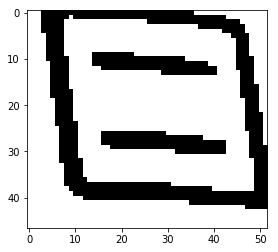

************ (15,)
[ 5355   778  4577   702   293   995  9945  4590  9167 11500 12202  6375
  6120  5125  6082]
************
occ-distance:  [[-0.02941333]]
prediction:  [ 1.] [ 4.33451216]


************ (15,)
[ 4121   143  3978   245    51   194  9221  5100  9078 11577 11822  5808
  5963  5769  5859]
************
occ-distance:  [[-0.03428499]]
prediction:  [ 1.] [ 2.1591213]


************ (15,)
[2306 1592 3898  956 1274  318 5852 3546 7444 7943 8899 3622 4003 4321 4896]
************
occ-distance:  [[-0.01778153]]
prediction:  [ 0.] [-4.44407588]


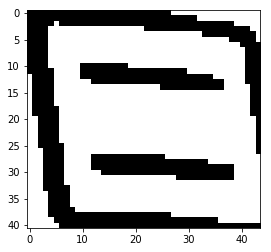

************ (15,)
[ 4056   356  4412   331    26   305  9079  5023  9435 11934 11603  5636
  5993  6298  5610]
************
occ-distance:  [[-0.04743157]]
prediction:  [ 1.] [ 2.84478422]


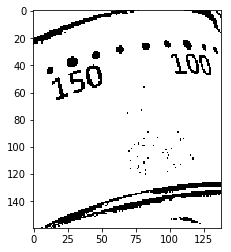

************ (15,)
[2389  791 3180   76  367  291 5928 3539 6719 8055 8131 3570 4194 4485 3937]
************
occ-distance:  [[-0.01499184]]
prediction:  [ 0.] [-9.32516923]


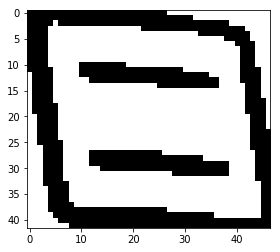

************ (15,)
[ 4845   867  3978   765   816    51  8415  3570  7548 10149  9384  5355
  4845  4794  4539]
************
occ-distance:  [[-0.03438737]]
prediction:  [ 1.] [ 3.18784952]


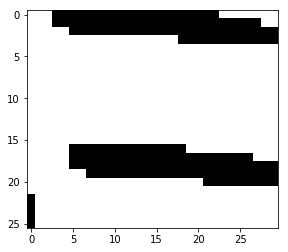

************ (15,)
[ 4399    13  4386  1046   281   765  9002  4603  8989 11820 10774  5700
  5355  6120  5419]
************
occ-distance:  [[-0.04975969]]
prediction:  [ 0.] [-0.09853141]


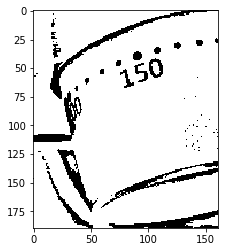

************ (15,)
[ 4320   390  4710   306   288    18  9254  4934  9644 11763 12069  5944
  5837  5819  6232]
************
occ-distance:  [[-0.04102274]]
prediction:  [ 1.] [ 0.39990977]


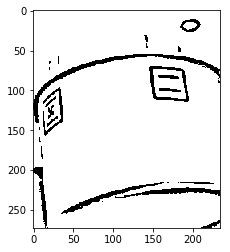

************ (15,)
[ 4336   447  3889   191   319   128  8416  4080  7969 10328 10137  5419
  5037  4909  5100]
************
occ-distance:  [[-0.01775603]]
prediction:  [ 0.] [-1.65064704]


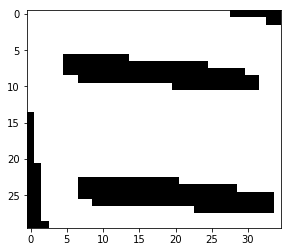

************ (15,)
[ 4947   768  4179   711    99   612  9792  4845  9024 11475 12186  6120
  5967  5355  6219]
************
occ-distance:  [[-0.04573273]]
prediction:  [ 1.] [ 0.16765227]


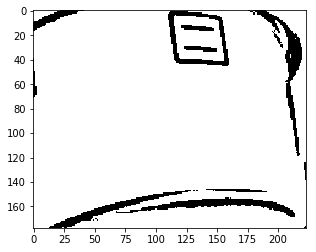

In [250]:
importlib.reload(classify_lib)
print('number of candidates: ', len(candidates))
p = 'C:/Users/alici/Uni/Bayer_Praktikum/szenario_status/images/train_icons/anti_extracted/'
i=0

for x, y, w, h in candidates:
    window = img.adapThres[y:y+h, x:x+w]
    winColor = img. img[y:y+h, x:x+w]
    
    hog = classify_lib.getResizedHOGfeature(window, ppc=ppc, size=(32,32))
#     daisy = classify_lib.getResizedDAISYfeature(window, size=(32,32))
    haar = classify_lib.getResizedHaarFeature(window)

    
    pred, dist = classify_lib.predictOneClassSVM(occ_clf, hog)
#     print(dist)
    if not dist> -0.05:#pred == 1:#dist > -0.05:
        continue
    
#     #hog = getResizedHOGfeature(window, ppc=ppc, showHist = True, size=(32,32))

    print('************', haar.shape)
    print(haar)
    print('************')
    prediction = clf.predict([haar])
    distCLF = clf.decision_function([haar])


    
    print('occ-distance: ', dist)
    print('prediction: ', prediction, distCLF)
    
    plt.imshow(window, cmap='gray')
    plt.show()
    i+=1